<a href="https://colab.research.google.com/github/lorylei/Cognitive-science-project/blob/main/seq2seq_julius_version_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


In [9]:
# data dir Sebastian Colab 
#data_path ="KU/NLP_advanced/"
# data dir X Colab 
#data_path ="X)/"
# set to empty string if not using colab
data_path = ""

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import random
import numpy as np
from copy import deepcopy

In [11]:
# set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 1

# Load data and prepare the dataloader

In [4]:
def load_data(filename):
    """Load data from file and extract commands and action."""

    with open(filename) as source:
        for line in source:
            # Tokenize on whitespace
            line = line.rstrip().split() 
            commands = line[1:line.index("OUT:")]
            actions = line[line.index("OUT:")+1:]
            yield commands, actions

In [5]:
def make_vocab(data):
    """Create vocabularies for commands and actions respectively."""
    
    src_vocab = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
    tgt_vocab = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}

    for commands, actions in data:
        for cmd, act in zip(commands, actions):
            if cmd not in src_vocab:
                src_vocab[cmd] = len(src_vocab)
            if act not in tgt_vocab:
                tgt_vocab[act] = len(tgt_vocab)

    return src_vocab, tgt_vocab

In [6]:
class ScanDataset(Dataset):
    """Class containing the Scan dataset."""
    
    def __init__(self, src_vocab, tgt_vocab, filename):
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        # Each command/action is encoded with the corresponding vocab ID.
        self.src = [[self.src_vocab.get(w, 3) for w in s] for s, t in load_data(filename)]
        self.tgt = [[self.tgt_vocab.get(w, 3) for w in t] + [2] for s, t in load_data(filename)]

    def __getitem__(self, idx):
        return self.src[idx], self.tgt[idx]

    def __len__(self):
        return len(self.src)

In [13]:
class ScanBatcher():
    """Class to handle batching (collate function)."""
    
    def __call__(self, batch):
        srcs, tgts = zip(*batch)

        # Determine the maximal length of a source/target sequence
        max_src_len = max(len(s) for s in srcs)
        max_tgt_len = max(len(t) for t in tgts)

        # Create the source/target tensors
        S = torch.LongTensor([s + [0] * (max_src_len - len(s)) for s in srcs])
        T = torch.LongTensor([t + [0] * (max_tgt_len - len(t)) for t in tgts])

        return S.to(device), T.to(device)

### Test the dataloader

In [14]:
src_vocab, tgt_vocab = make_vocab(load_data(data_path+"simple_split/tasks_train_simple.txt"))
train_dataset = ScanDataset(src_vocab, tgt_vocab, data_path+"simple_split/tasks_train_simple.txt")
batcher = ScanBatcher()
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=batcher)

In [15]:
for example_batch in train_loader:
    print(example_batch[0])
    print(example_batch[1])
    break

tensor([[ 4,  5,  6, 10, 13,  4,  5,  6, 10]], device='cuda:0')
tensor([[4, 4, 5, 4, 4, 5, 4, 4, 5, 4, 4, 5, 4, 4, 5, 4, 4, 5, 2]],
       device='cuda:0')


# Base architecture

In [18]:
# integrate attention into the model(please check it)

class BahdanauAttention(nn.Module):

    def __init__(self, hidden_dim=200):
        super().__init__()
        self.U = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.W = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, decoder_hidden, encoder_output, src_mask):
        """
        decoder_hidden: [layer_size, batch_size, hidden_dim]
        encoder_output: [batch_size, src_len, hidden_dim]
        src_mask: [batch_size, src_len]
        return: context vector [batch_size, hidden_dim] and attention weights [batch_size, src_len]
        """
        # scores:[batch_size, src_len, hidden_size]
        scores = torch.tanh(self.W(decoder_hidden[-1,:,:]).unsqueeze(1) + self.U(encoder_output))
        # multiply scores by v to get attention weights
        attention = self.v(scores).squeeze(2) # [batch_size, src_len]
        # multiply src_mask to make sure that the attention of padding tokens is 0
        # set to -inf to make sure that the softmax of these tokens is 0
        attention.data.masked_fill_(src_mask, -float('inf'))
        # softmax to get normalized weights
        alpha = F.softmax(attention, dim=1).unsqueeze(1) # [batch_size, 1, src_len]
        # The context vector is the alpha-weighted sum of the encoder outputs.
        context = torch.bmm(alpha, encoder_output).squeeze(1) # [batch_size, hidden_dim]
        return context, alpha

In [20]:
# test attention
attention = BahdanauAttention(hidden_dim=200)
# layer size, batch size, hidden size
hidden = torch.randn(2, 1, 200)
# batch_size, src_len, hidden_dim
encoder_output = torch.randn(1, 7, 200)
src_mask = torch.tensor([[0, 0, 0, 0, 0, 0, 1]])
context, alpha = attention(hidden, encoder_output, src_mask)
print("context:",context.shape)
print("alpha:",alpha.shape)

context: torch.Size([1, 200])
alpha: torch.Size([1, 1, 7])


In [21]:
class Encoder(nn.Module):
    """Class to represent the encoder."""

    def __init__(self, input_size, hidden_size, num_layers, dropout, rnn_type):
        super().__init__()
        self.rnn_type = rnn_type
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size, device=device)
        if rnn_type == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, 
                              dropout=dropout, batch_first=True, device=device)
        else:
            self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, 
                               dropout=dropout, batch_first=True, device=device)
        

    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output, hidden = self.rnn(embedded, hidden)
        return output, hidden

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)
        return hidden if self.rnn_type == "gru" else (hidden, hidden)

In [22]:
class Decoder(nn.Module):
    """Class to represent the decoder."""

    def __init__(self, output_size, hidden_size, num_layers, dropout, rnn_type):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(output_size, hidden_size, device=device)
        if rnn_type == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, 
                              dropout=dropout, batch_first=True, device=device)
        else:
            self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, 
                               dropout=dropout, batch_first=True, device=device)
        self.out = nn.Linear(hidden_size, output_size, device=device)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, hidden, tgt):
            batch_size, tgt_len = tgt.shape
            # Lookup the embeddings for the previous command (in each sequence)
            embedded = self.embedding(tgt)
            # Initialise the list of outputs
            outputs = []
            for i in range(tgt_len):
                # Get the embedding for the previous command (in each sequence)
                prev_embedded = embedded[:, i]
                # Take one step with the RNN
                output, hidden = self.step(prev_embedded, hidden)
                # Update the list of outputs (in each sequence)
                outputs.append(output)
            return torch.cat(outputs, dim=1)

    def decode(self, encoder_output, hidden, max_len):
        batch_size = encoder_output.size(0)
        # Initialise the list of generated actions (in each sequence)
        generated = [torch.ones(batch_size, dtype=torch.long, device=device)]
        # Initialise the list of outputs (to be used when teacher_forcing=False)
        outputs = []
        for i in range(max_len):
            # Get the embedding for the previous action (in each sequence)
            prev_embedded = self.embedding(generated[-1])
            # Take one step with the RNN
            output, hidden = self.step(prev_embedded, hidden)
            # Update the list of generated actions (in each sequence)
            generated.append(output.argmax(-1).squeeze(1))
            outputs.append(output)
        generated = [x.unsqueeze(1) for x in generated[1:]]
        return torch.cat(generated, dim=1), torch.cat(outputs, dim=1)
    
    def step(self, prev_embedding, hidden):
        output, hidden = self.rnn(prev_embedding.unsqueeze(1), hidden)
        output = self.softmax(self.out(output))
        return output, hidden

In [26]:
class AttentionDecoder(nn.Module):
    """Class to represent the decoderwith attention."""

    def __init__(self, output_size, hidden_size, num_layers, dropout, rnn_type):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(output_size, hidden_size, device=device)
        self.attention = BahdanauAttention(hidden_dim=hidden_size)
        
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        if rnn_type == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, 
                              dropout=dropout, batch_first=True, device=device)
      
        else:
            self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, 
                               dropout=dropout, batch_first=True, device=device)
        self.out = nn.Linear(hidden_size, output_size, device=device)
        self.linear = nn.Linear(hidden_size*2, output_size, device=device)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, encoder_output, hidden, tgt, mask):
            batch_size, tgt_len = tgt.shape
            # Lookup the embeddings for the previous command (in each sequence)
            embedded = self.embedding(tgt)
            # Initialise the list of outputs
            outputs = []
            atten_weights = []
          
            for i in range(tgt_len):
                # Get the embedding for the previous command (in each sequence)
                prev_embedded = embedded[:, i]
                # Take one step with the RNN
                output, hidden, atten_weight = self.step(prev_embedded, hidden, encoder_output, mask)
                # Update the list of outputs (in each sequence)
                outputs.append(output)
                atten_weights.append(atten_weight)
            
              
            return torch.cat(outputs, dim=1),  torch.cat(atten_weights, dim=1)

    def decode(self, encoder_output, hidden, max_len, mask):
        batch_size = encoder_output.size(0)
        # Initialise the list of generated actions (in each sequence)
        generated = [torch.ones(batch_size, dtype=torch.long, device=device)]
        # Initialise the list of outputs (to be used when teacher_forcing=False)
        outputs = []
        atten_weights = []
        for i in range(max_len):
            # Get the embedding for the previous action (in each sequence)
            prev_embedded = self.embedding(generated[-1])
            # Take one step with the RNN
            output, hidden, atten_weight = self.step(prev_embedded.squeeze(1), hidden, encoder_output, mask)
            # Update the list of generated actions (in each sequence)
            generated.append(output.argmax(-1))
            outputs.append(output)
            atten_weights.append(atten_weight)
        generated = [x.unsqueeze(1) for x in generated[1:]]
        return torch.cat(generated, dim=1).squeeze(2), torch.cat(outputs, dim=1).squeeze(2), torch.cat(atten_weights, dim=1)
    
    def step(self, input, hidden, encoder_output, mask):
        # use the hidden state of decoder output to make attention
        # attention with encoder output
        context, alpha = self.attention(hidden[0], encoder_output, src_mask=mask)
        # with train lable/prediction from previous step
        input_rnn = torch.cat([context, input], dim=1)
        input_rnn = self.attn_combine(input_rnn)
        output_rnn, hidden = self.rnn(input_rnn.unsqueeze(1), hidden)
        input_linear = torch.cat([hidden[0][-1,:,:],context], dim=1)
        output_linear = self.linear(input_linear)
        return output_linear.unsqueeze(1), hidden, alpha

In [27]:
class EncoderDecoder(nn.Module):
    """Class to represent the seq2seq model."""

    def __init__(self, src_vocab_size, tgt_vocab_size, hidden_size, 
                 num_layers, dropout, rnn_type, attention):
        super().__init__()
        self.encoder = Encoder(src_vocab_size, hidden_size, 
                               num_layers, dropout, rnn_type)
        self.attention = attention
        if self.attention == True:
          self.decoder = AttentionDecoder(tgt_vocab_size, hidden_size, 
                               num_layers, dropout, rnn_type,)
        else:
          self.decoder = Decoder(tgt_vocab_size, hidden_size, 
                               num_layers, dropout, rnn_type)

    def forward(self, src, tgt, teacher_forcing=True):
        batch_size, tgt_len = tgt.shape
        output, hidden = self.encoder(src, self.encoder.init_hidden(batch_size))
        if self.attention == True:
          #mask:mask(if src==0: True)
          if teacher_forcing:
              output, attention_weights = self.decoder.forward(output, hidden, tgt, src==0)
              return output, attention_weights
          else:
              _, output, attention_weights = self.decoder.decode(output, hidden, tgt_len, src==0)
              return output, attention_weights
        else:
              return self.decoder.forward(hidden, tgt) if teacher_forcing else self.decoder.decode(output, hidden, tgt_len)[1]

    def decode(self, src, max_len):
        batch_size, _ = src.shape
        encoder_output, hidden = self.encoder(src, self.encoder.init_hidden(batch_size))
        
        if self.attention == True:
          generated, _, atten_weights = self.decoder.decode(encoder_output, hidden, max_len, src==0)
          return generated, atten_weights
        else:
          return self.decoder.decode(encoder_output, hidden, max_len)[0]

### Test seq2seq model

In [28]:
#test decoder with attention and original decoder
encoder_decoder = EncoderDecoder(len(src_vocab), len(tgt_vocab), 200, 2, 0.5, "lstm", True).to(device)
forward_out, forward_atten_weights = encoder_decoder.forward(example_batch[0], example_batch[1])
decode_out, decode_atten_weights = encoder_decoder.decode(example_batch[0], example_batch[1][0].shape[0])
print(forward_out.shape)
print(decode_out.shape)
print(forward_atten_weights.shape)
print(decode_atten_weights.shape)

torch.Size([1, 19, 10])
torch.Size([1, 19])
torch.Size([1, 19, 9])
torch.Size([1, 19, 9])


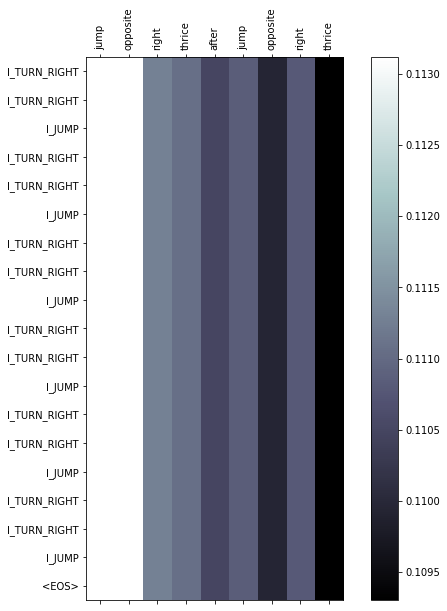

In [29]:
import matplotlib.ticker as ticker

# display the attention weights
def display_attention_weights(attention_weights, src, tgt):
    # if src and tgt are tensors, convert them to lists
    if isinstance(src, torch.Tensor):
        src = src.tolist()
    if isinstance(tgt, torch.Tensor):
        tgt = tgt.tolist()
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    attention_weights = attention_weights.squeeze(0).detach().cpu().numpy()
    cax = ax.matshow(attention_weights, cmap='bone')
    fig.colorbar(cax)
    
    # reverse the source and target vocabularies to get the words
    src_vocab_rev = {v: k for k, v in src_vocab.items()}
    tgt_vocab_rev = {v: k for k, v in tgt_vocab.items()}
    # convert the tokens to words and add to labels
    src = [src_vocab_rev[x] for x in src]
    tgt = [tgt_vocab_rev[x] for x in tgt]
    
    
    ax.set_xticklabels([''] + src, rotation=90)
    ax.set_yticklabels([''] + tgt)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

# display the attention weights
src, tgt = example_batch[0][0], example_batch[1][0]
display_attention_weights(forward_atten_weights, src, tgt)


# Interpreter

In [30]:
class Interpreter(object):
    """Wrapper class for seq2seq model that enables interactive usage."""

    def __init__(self, src_vocab, tgt_vocab, hidden_size, 
                 num_layers, attention=False, dropout=0, rnn_type="lstm"):
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention = attention
        self.model = EncoderDecoder(len(src_vocab), len(tgt_vocab), hidden_size, 
                                    num_layers, dropout, rnn_type, attention).to(device)

    def _interpret(self, commands):
        """Get model output in readable format for provided commands."""
        # Encode each command sequence
        encoded = [[self.src_vocab.get(w, 3) for w in s.split()] for s in commands]
        # Determine the maximal length of an encoded command sequence
        max_len = max(len(e) for e in encoded)
        # Build the input tensor, padding all sequences to the same length
        src = torch.LongTensor([e + [0] * (max_len - len(e)) for e in encoded]).to(device)
        # Run the decoder and convert the result into nested lists
        with torch.no_grad():
            if self.model.attention == True:
                output, _ = self.model.decode(src, max_len*5)
            else:
                output = self.model.decode(src, max_len*5)
            decoded = tuple(d.cpu().numpy().tolist() for d in output) # max_len?
        

        # Prune each decoded action sequence after the first <EOS>
        i2w = {i: w for w, i in self.tgt_vocab.items()}
        result = []
        for d in decoded:
            d = [i2w[i] for i in d]
            try:
                eos_index = d.index("<EOS>")
                del d[eos_index:]
            except:
                pass
            result.append(" ".join(d))
        return result

    def interpret(self, commands):
        """Interpretation function that transforms commands to actions."""
        interpreted = self._interpret(commands)
        return interpreted

### Test interpreter

In [31]:
# This version is pretty bad since it has not been trained yet
#interpreter = Interpreter(src_vocab, tgt_vocab, hidden_size=200, num_layers=2, attention=True, dropout=0.5, rnn_type="gru")
interpreter = Interpreter(src_vocab, tgt_vocab, hidden_size=200, num_layers=2, attention=False, dropout=0.5, rnn_type="gru")
interpreter.interpret(["turn opposite right thrice", "turn opposite left twice"])

['<PAD> I_RUN',
 '<PAD> I_TURN_LEFT I_TURN_LEFT I_RUN <UNK> <UNK> I_TURN_LEFT I_JUMP <PAD> <PAD> I_TURN_LEFT I_JUMP <UNK> I_TURN_RIGHT <UNK> I_RUN I_RUN I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT']

# Training and evaluation

In [32]:
def train(interpreter, train_dataset, n_trials=100000, batch_size=1, lr=0.001):
    """Run training for provided interpreter (seq2seq model)."""

    # Prepare the dataloader
    batcher = ScanBatcher()
    sampler = torch.utils.data.RandomSampler(train_dataset, replacement=True, num_samples=n_trials)
    train_loader = DataLoader(train_dataset, batch_size=1, sampler=sampler, collate_fn=batcher)

    # Initialise the optimiser
    optimizer = torch.optim.Adam(interpreter.model.parameters(), lr=lr)

    # Calculate initial accuracy
    #print("Calculating initial accuracy...")
    #train_accuracy = evaluate(interpreter, train_loader)
    #print("Initial accuracy: {:.2f}%".format(train_accuracy * 100))
    print("Training...")
    # Make it possible to interrupt the training
    try:
        with tqdm(total=n_trials) as pbar:
            losses = []
            for i, (src_batch, tgt_batch) in enumerate(train_loader):
                interpreter.model.train()
                
                # Create a shifted version of tgt_batch containing the previous words
                batch_size, tgt_len = tgt_batch.shape
                bos = torch.ones(batch_size, 1, dtype=torch.long, device=device)
                tgt_batch_shifted = torch.cat((bos, tgt_batch[:, :-1]), dim=1)

                # Forward pass (do teacher forcing with probability 0.5)
                teacher_forcing = random.random() < 0.5
                scores = interpreter.model(src_batch, tgt_batch_shifted, teacher_forcing=teacher_forcing)
                if interpreter.model.attention == True:
                  scores, _ = scores #do not use attention weights

                # Backward pass
                optimizer.zero_grad()
                loss = F.cross_entropy(scores.view(-1, len(tgt_vocab)), tgt_batch.view(-1), ignore_index=0)
                loss.backward()
                nn.utils.clip_grad_norm_(interpreter.model.parameters(), max_norm=5.0) # Gradient clipping
                optimizer.step()

                # Update the diagnostics
                losses.append(loss.item())
                pbar.set_postfix(loss=(sum(losses) / len(losses)))#, train_accuracy=train_accuracy)
                #update progress bar
                pbar.update(len(src_batch))
        
                # Evaluate current model on train data
                #if i % 250 == 0:
                #    train_accuracy = evaluate(interpreter, train_loader)
                
    except KeyboardInterrupt:
        pass
    
    #print(f"Final train accuracy: {train_accuracy}")
    return interpreter, losses

In [33]:
def evaluate(interpreter, data_loader):
    """Evaluate model on data (results reported in accuracy)."""      

    correct, num_instances = 0, 0
    interpreter.model.eval()

    for i, (src_batch, tgt_batch) in enumerate(data_loader):
        batch_size, tgt_len = tgt_batch.shape

        # Generate actions
        with torch.no_grad():
            preds = interpreter.model.decode(src_batch, tgt_len)

        if interpreter.model.attention == True:
            preds, attention_weights = preds
          
        # calculate train accuracy for batch (make more efficient?)
        for i, tgt in enumerate(tgt_batch):
            idx = (tgt == 2).nonzero(as_tuple=True)[0].item()
            # Ignore everything after <EOS> token
            tgt = tgt[:idx]
            pred = preds[i, :idx]
            # Increment number of correct and total actions
            correct += 1 if torch.all(pred == tgt) else 0
            num_instances += 1

    return correct / num_instances

# Experiments

In [34]:
def prepare_data(train_file, test_file):
    """Create vocabs, datasets and test dataloader for the given files."""
    # Build the vocabularies
    src_vocab, tgt_vocab = make_vocab(load_data(train_file))
    # Prepare the dataset
    train_dataset = ScanDataset(src_vocab, tgt_vocab, train_file)
    test_dataset = ScanDataset(src_vocab, tgt_vocab, test_file)
    # Prepare dataloader for test data
    batcher = ScanBatcher()
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=batcher)
    return src_vocab, tgt_vocab, train_dataset, test_loader

In [35]:
def plot_bar(xs, ys, title, xlabel, ylabel, fontsize=12, percentages=True):
    """Make bar plot similar to the ones in the paper."""
    index = np.arange(len(ys))
    plt.figure(figsize=(8, 5))
    plt.bar(index, ys)
    plt.title(title, fontsize=fontsize+4)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    x_arr = [str(x) + "%" if percentages else str(x) for x in xs]
    # y ticks from 0 to 100
    plt.yticks(np.arange(0, 101, 20))
    plt.xticks(index, x_arr, fontsize=fontsize, rotation=30)
    plt.show()

# plot losses
def plot_losses(losses, title, xlabel, ylabel,fig_size=(8,5)):
    plt.figure(figsize=fig_size)
    plt.plot(losses)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


## Overall-best architecture

In [36]:
src_vocab, tgt_vocab, train_dataset, test_loader = prepare_data(data_path+"simple_split/tasks_train_simple.txt", 
                                                                data_path+"simple_split/tasks_test_simple.txt")
                                                            
interpreter = Interpreter(src_vocab, tgt_vocab, hidden_size=200, 
                          num_layers=2, attention= True, dropout=0.5, rnn_type="lstm")
interpreter, losses = train(interpreter, train_dataset)
print(f"Final test accuracy: {evaluate(interpreter, test_loader)}")

Training...


  0%|          | 0/100000 [00:00<?, ?it/s]

Final test accuracy: 0.6262553802008608


In [ ]:
plot_losses(losses, "Losses", "Epoch", "Loss", fig_size = (8,5))

## Experiment 1

In [ ]:
# Experiment 1a
src_vocab, tgt_vocab, train_dataset, test_loader = prepare_data(data_path+"simple_split/tasks_train_simple.txt", 
                                                                data_path+"simple_split/tasks_test_simple.txt")
interpreter = Interpreter(src_vocab, tgt_vocab, hidden_size=200, 
                          num_layers=2, dropout=0, rnn_type="lstm")
interpreter,losses = train(interpreter, train_dataset)
print(f"Final test accuracy: {evaluate(interpreter, test_loader)}")

KeyboardInterrupt: 

In [ ]:
plot_losses(losses, "Losses", "Epoch", "Loss", fig_size = (8,5))


In [ ]:
import os
import datetime
#make new directory for results
#if not already made
if not os.path.exists(data_path+"results"):
    os.mkdir(data_path+"results")

losses = []
# save losses, and final test accuracy
test_acc_1a = evaluate(interpreter, test_loader)
# save as npy
date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
file_name = "test_acc_1a_"+str(test_acc_1a) + "_losses" + date + ".npy"
file_path = data_path+"results/"+file_name
print(file_path)
np.save(file_path, losses)

results
results/test_acc_1a_0.0_losses2022-12-04_12-52-38.npy


In [ ]:
# Experiment 1b
training_sizes = [1, 2, 4, 8, 16, 32, 64]
size_accs = []
for size in training_sizes:
    src_vocab, tgt_vocab, train_dataset, test_loader = prepare_data(data_path+f"simple_split/size_variations/tasks_train_simple_p{size}.txt", 
                                                                    data_path+f"simple_split/size_variations/tasks_test_simple_p{size}.txt")
    interpreter = Interpreter(src_vocab, tgt_vocab, hidden_size=200,
                              num_layers=2, dropout=0, rnn_type="lstm")
    interpreter, losses= train(interpreter, train_dataset)
    acc = evaluate(interpreter, test_loader)
    size_accs.append(acc)

plot_bar(training_sizes, size_accs, 
         "Experiment 1b",
         "Percent of commands used for training",
         "Accuracy on new commands (%)")

# SAVE DATA 1B

# save training_sizes and size_accs as npy in one file
date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
file_name = "test_accs_1b_and_training_sizes" + date + ".npy"
file_path = data_path+"results/"+file_name
np.save(file_path, [training_sizes, size_accs])

# LOAD DATA 1B
#path = data_path+"results/"+ FILENAME
# training_sizes, size_accs = np.load(path, allow_pickle=True)
# plot_bar(training_sizes, size_accs,
#             "Experiment 1b",
#             "Percent of commands used for training",
#             "Accuracy on new commands (%)")


KeyboardInterrupt: 

In [ ]:
# run experiment 1b five times
training_sizes = [1, 2, 4, 8, 16, 32, 64]
size_accs = []
for i in range(5):
    accs_i = []
    for size in training_sizes:
        src_vocab, tgt_vocab, train_dataset, test_loader = prepare_data(data_path+f"simple_split/size_variations/tasks_train_simple_p{size}.txt", 
                                                                        data_path+f"simple_split/size_variations/tasks_test_simple_p{size}.txt")
        interpreter = Interpreter(src_vocab, tgt_vocab, hidden_size=200,
                                  num_layers=2, dropout=0, rnn_type="lstm")
        interpreter, losses= train(interpreter, train_dataset)
        acc = evaluate(interpreter, test_loader)
        accs_i.append(acc)
    size_accs.append(accs_i)

size_accs_avg = np.mean(size_accs, axis=0)
plot_bar(training_sizes, size_accs_avg,
            "Experiment 1b - avg 5 runs",
            "Percent of commands used for training",
            "Accuracy on new commands (%)")


# save training_sizes and size_accs as npy in one file
date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
file_name = "test_accs_1b_5_runs_and_training_sizes" + date + ".npy"
file_path = data_path+"results/"+file_name
np.save(file_path, [training_sizes, size_accs])

Training...


  0%|          | 97/100000 [00:09<2:39:22, 10.45it/s, loss=1.87]


## Experiment 2

In [37]:
class ScanDataset(Dataset):
    """Class containing the Scan dataset."""

    def __init__(self, src_vocab, tgt_vocab, filename, row_filter=None, debug=False):
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        # Each command/action is encoded with the corresponding vocab ID.
        self.src = []
        self.tgt = []
        for s, t in load_data(filename):
            if debug:
                print(len(t), (len(s)))
            if not row_filter or row_filter(s, t):
                self.src.append([self.src_vocab.get(w, 3) for w in s])
                self.tgt.append([self.tgt_vocab.get(w, 3) for w in t] + [2])
                
    def __getitem__(self, idx):
        return self.src[idx], self.tgt[idx]

    def __len__(self):
        return len(self.src)

In [40]:
src_vocab, tgt_vocab, train_dataset, test_loader = prepare_data(data_path+"length_split/tasks_train_length.txt", 
                                                                data_path+"length_split/tasks_test_length.txt")
interpreter = Interpreter(src_vocab, tgt_vocab, hidden_size=200, 
                          num_layers=2, dropout=0, rnn_type="lstm")
interpreter, losses = train(interpreter, train_dataset)
print(f"Length split test accuracy: {evaluate(interpreter, test_loader)}")

Training...


  0%|          | 0/100000 [00:00<?, ?it/s]

Length split test accuracy: 0.18035714285714285


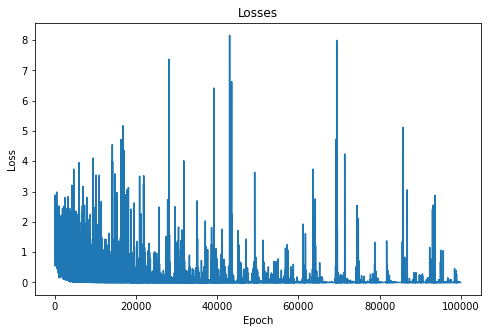

In [41]:
plot_losses(losses, "Losses", "Epoch", "Loss", fig_size = (8,5))

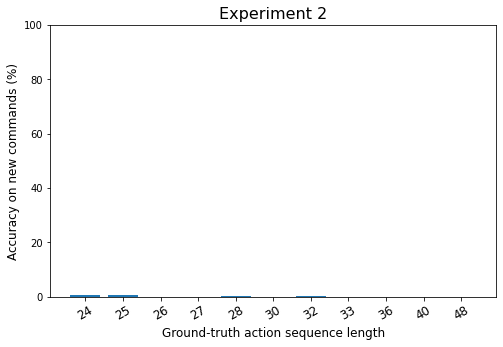

In [44]:
import datetime

lengths = [24, 25, 26, 27, 28, 30, 32, 33, 36, 40, 48]
length_accs = []
for length in lengths:
    row_filter = lambda s, t: len(t) == length
    length_test_dataset = ScanDataset(
        src_vocab, tgt_vocab,
        data_path+"length_split/tasks_test_length.txt",
        row_filter=row_filter,
        debug=False
    )

    length_test_loader = DataLoader(length_test_dataset, batch_size=32, shuffle=True, collate_fn=batcher)
    acc = evaluate(interpreter, length_test_loader)
    length_accs.append(acc)

plot_bar(lengths, length_accs, 
         "Experiment 2",
         "Ground-truth action sequence length",
         "Accuracy on new commands (%)",
         percentages=False)

# SAVE DATA LENGTH ACCURACIES with lengths
date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
file_name = "exp2_length_accs_24_to_48" + date + ".npy"
file_path = data_path+"results/"+file_name
np.save(file_path, [lengths, length_accs])

# LOAD DATA LENGTH ACCURACIES 
# 
#path = data_path+"results/" + (insert FILENAME)
# lengths, length_accs = np.load(path, allow_pickle=True)
# plot_bar(lengths, length_accs,
#             "Experiment 2",
#             "Ground-truth action sequence length",
#             "Accuracy on new commands (%)",
#             percentages=False)





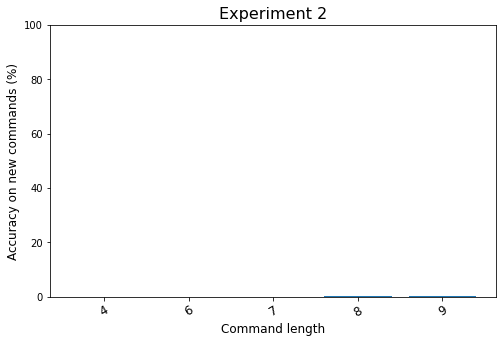

In [46]:
command_lengths = [4, 6, 7, 8, 9]
command_length_accs = []
for command_length in command_lengths:
    row_filter = lambda s, t: len(s) == command_length
    command_length_test_dataset = ScanDataset(
        src_vocab, tgt_vocab,
        data_path+"length_split/tasks_test_length.txt",
        row_filter=row_filter
    )

    command_length_test_loader = DataLoader(command_length_test_dataset, batch_size=32, shuffle=True, collate_fn=batcher)
    acc = evaluate(interpreter, command_length_test_loader)
    command_length_accs.append(acc)

plot_bar(command_lengths, command_length_accs, 
         "Experiment 2",
         "Command length",
         "Accuracy on new commands (%)", 
         percentages=False)

# SAVE DATA COMMAND LENGTH ACCURACIES with command_lengths
date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
file_name = "exp2_command_length_accs_4_to_9" + date + ".npy"
file_path = data_path+"results/"+file_name
np.save(file_path, [command_lengths, command_length_accs])

# LOAD DATA COMMAND LENGTH ACCURACIES
#path = data_path+"results/" + (insert FILENAME)
# command_lengths, command_length_accs = np.load(path, allow_pickle=True)
# plot_bar(command_lengths, command_length_accs,
#             "Experiment 2",
#             "Command length",
#             "Accuracy on new commands (%)",
#             percentages=False)



## Experiment 3

In [ ]:
# two variants : add prim jump and add prim turn_left
# load data from add_prim_split folder
path_train_jump = data_path+"add_prim_split/tasks_train_addprim_jump.txt"
path_test_jump = data_path+"add_prim_split/tasks_test_addprim_jump.txt"
path_train_turn_left = data_path+"add_prim_split/tasks_train_addprim_turn_left.txt"
path_test_turn_left = data_path+"add_prim_split/tasks_test_addprim_turn_left.txt"

### jump primitive - experiment 3

In [ ]:
# make dataset and run experiment
src_vocab, tgt_vocab, train_dataset_jump, test_loader_jump = prepare_data(path_train_jump, path_test_jump)
# The best performance was 1.2% accuracy (LSTM, attention, one layer, 100 hidden units, dropout 0.1). 
interpreter_jump = Interpreter(src_vocab, tgt_vocab, hidden_size=100, num_layers=2, attention=True, dropout=0.1, rnn_type="lstm")
# train and evaluate
interpreter_jump, losses_jump = train(interpreter_jump, train_dataset_jump)
print(f"Add prim jump test accuracy: {evaluate(interpreter_jump, test_loader_jump)}")

plot_losses(losses_jump, "Losses", "Epoch", "Loss", fig_size = (8,5))

# save results and losses   
date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
acc_addprim_jump = evaluate(interpreter_jump, test_loader_jump)
file_path = "exp3_addprim_jump_acc"+str(acc_addprim_jump)+"_"+date + ".npy"
np.save(file_path, losses_jump)

# load results and losses
#path = data_path+"results/" + (insert FILENAME)
# losses_jump = np.load(path, allow_pickle=True)
# plot_losses(losses_jump, "Losses", "Epoch", "Loss", fig_size = (8,5))



KeyboardInterrupt: 

### turn_left primitive - experiment 3

In [ ]:
src_vocab, tgt_vocab, train_dataset_turn_left, test_loader_turn_left = prepare_data(path_train_turn_left, path_test_turn_left)
# Turn left best GRU network with attention, one layer with 100 hidden units, and dropout of 0.1
interpreter_turn_left = Interpreter(src_vocab, tgt_vocab, hidden_size=100, num_layers=1, attention=True, dropout=0.1, rnn_type="gru")
# train and evaluate
interpreter_turn_left, losses_turn_left = train(interpreter_turn_left, train_dataset_turn_left)
print(f"Add prim turn left test accuracy: {evaluate(interpreter_turn_left, test_loader_turn_left)}")

plot_losses(losses_turn_left, "Losses", "Epoch", "Loss", fig_size = (8,5))

# save results and losses
date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
acc_addprim_turn_left = evaluate(interpreter_turn_left, test_loader_turn_left)
file_path = "exp3_addprim_turn_left_acc"+str(acc_addprim_turn_left)+"_"+date + ".npy"
np.save(file_path, losses_turn_left)

# load results and losses
#path = data_path+"results/" + (insert FILENAME)
# losses_turn_left = np.load(path, allow_pickle=True)
# plot_losses(losses_turn_left, "Losses", "Epoch", "Loss", fig_size = (8,5))


/usr/local/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


KeyboardInterrupt: 

"We observe that even in the successful “turn left” case model errors are surprising. One would expect such errors to be randomly distributed, or perhaps to pertain to the longest commands or action sequences.

Instead, all 45 errors made by the model are conjunctions where one of the components is simple “turn left” (22 cases) or “turn left thrice” (23 cases)."

In [ ]:
def index(tensor, value, ith_match:int =0):
    """
    Returns generalized index (i.e. location/coordinate) of the first occurence of value
    in Tensor. For flat tensors (i.e. arrays/lists) it returns the indices of the occurrences
    of the value you are looking for. Otherwise, it returns the "index" as a coordinate.
    If there are multiple occurences then you need to choose which one you want with ith_index.
    e.g. ith_index=0 gives first occurence.

    Reference: https://stackoverflow.com/a/67175757/1601580
    :return:
    """
    # bool tensor of where value occurred
    places_where_value_occurs = (tensor == value)
    # get matches as a "coordinate list" where occurence happened
    matches = (tensor == value).nonzero()  # [number_of_matches, tensor_dimension]
    if matches.size(0) == 0:  # no matches
        return -1
    else:
        # get index/coordinate of the occurence you want (e.g. 1st occurence ith_match=0)
        index = matches[ith_match]
        return index


# get all examples that the turn left model got wrong
wrong_turn_left = []
for s, t in test_loader_turn_left:
    # get output from decoder
    pred = interpreter_turn_left.model(s, t)
    if interpreter_turn_left.attention:
        pred = pred[0]
    # get argmax of output
    pred = torch.argmax(pred, dim=2)
    # loop over the batch
    for i in range(len(pred)):
        pred_i = pred[i]
        t_i = t[i]
        
        if 2 in pred_i:
            # find index of first <EOS> token
            idx = index(pred_i, 2)
            if idx != -1:
                pred_i = pred_i[:idx]
                t_i = t_i[:idx]
        # print lengths
        # Increment number of correct and total actions
        if not torch.all(pred_i == t_i):
            wrong_turn_left.append((s[i], t[i], pred[i]))
               

# get all examples that the jump model got wrong
wrong_jump = []
for s, t in test_loader_jump:
    # get output from decoder
    pred = interpreter_jump.model(s, t)
    if interpreter_jump.attention:
        pred = pred[0]
    # get argmax of output
    pred = torch.argmax(pred, dim=2)
    # loop over the batch
    for i in range(len(pred)):
        pred_i = pred[i]
        t_i = t[i]
        
        if 2 in pred_i:
            # find index of first <EOS> token
            idx = index(pred_i, 2)
            if idx != -1:
                pred_i = pred_i[:idx]
                t_i = t_i[:idx]
        # print lengths
        # Increment number of correct and total actions
        if not torch.all(pred_i == t_i):
            wrong_jump.append((s[i], t[i], pred[i]))

print(f"Turn left model got {len(wrong_turn_left)} wrong")
# procentage
print(f"Turn left model got {len(wrong_turn_left)/len(test_loader_turn_left)} wrong")

print(f"Jump model got {len(wrong_jump)} wrong")
# procentage
print(f"Jump model got {len(wrong_jump)/len(test_loader_jump)} wrong")


Turn left model got 1208 wrong
Jump model got 7706 wrong
